# Background


This notebook will show how to import a stack of DICOM images and place them in numpy

Following this tutorial:
- [DICOM in Python: Importing medical image data into NumPy with PyDICOM and VTK](https://pyscience.wordpress.com/2014/09/08/dicom-in-python-importing-medical-image-data-into-numpy-with-pydicom-and-vtk/)
- [Image Segmentation with Python and SimpleITK](https://pyscience.wordpress.com/2014/10/19/image-segmentation-with-python-and-simpleitk/)

# Imports

In [1]:
import os
import numpy
import SimpleITK
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Functions

sitk_show(img, title=None, margin=0.05, dpi=40): This function uses matplotlib.pyplot to quickly visualize a 2D SimpleITK.Image object under the img parameter. The code is pretty much entirely matplotlib but there’s one point you should pay attention to so here’s the code:

As you can see in the first line of the function we convert the SimpleITK.Image object to a numpy.ndarray through the GetArrayFromImage function which resides directly under the SimpleITK module. The opposite can be done through the GetImageFromArray function which just takes a numpy.ndarray and returns a SimpleITK.Image object.

However!, there’s a serious catch to this conversion! Be careful! If you were to have a SimpleITK.Image object with a size/shape of 200x100x50, then upon conversion to a numpy.ndarray that object would exhibit a shape of 50x100x200, i.e., the axes would be backwards.

The reason behind this is briefly outlined in this SimpleITK notebook by the SimpleITK author. It turns out that the SimpleITK.Image class doesn’t exactly have a bracket ([ and ]) operator but instead uses the GetPixel method which takes in a pixel index in a (x, y, z) order, i.e., the internal array is stored in an ‘x-fastest’ fashion. However, numpy internally stores its arrays in a ‘z-fastest’ fashion and takes an index in a (z, y, x) order. As a result you get the axes backwards!

Now, what does that mean for you? Well for one it means you need to be careful with your indices depending on whether you’re addressing the SimpleITK.Image or a numpy.ndarray derivative. It also means that the result of the sitk_show helper-function, which uses the GetArrayFromImage method we’re discussing, shows you the numpy view of the array and needs to be taken with a grain of salt. Lastly, when you feed point indices to SimpleITK for different algorithms, as we’ll see later, these indices need to be in the SimpleITK order and not the NumPy order.

I should state here that one can easily use numpy.transpose to bring the axes in the derivative numpy.ndarray in their ‘proper’ order. However, the array within SimpleITK is what it is and unless you just want to use SimpleITK to load data and then play around with NumPy there’s little point to it.

In [2]:
def sitk_show(img, title=None, margin=0.05, dpi=40 ):
    nda = SimpleITK.GetArrayFromImage(img)
    spacing = img.GetSpacing()
    figsize = (1 + margin) * nda.shape[0] / dpi, (1 + margin) * nda.shape[1] / dpi
    extent = (0, nda.shape[1]*spacing[1], nda.shape[0]*spacing[0], 0)
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])

    plt.set_cmap("gray")
    ax.imshow(nda,extent=extent,interpolation=None)
    
    if title:
        plt.title(title)
    
    plt.show()

In [62]:
def sitk_showNorm(img, title=None, margin=0.05, dpi=40 ):
    nda = SimpleITK.GetArrayFromImage(img)
    # normalize
    nda = nda/nda.max()
    spacing = img.GetSpacing()
    figsize = (1 + margin) * nda.shape[0] / dpi, (1 + margin) * nda.shape[1] / dpi
    extent = (0, nda.shape[1]*spacing[1], nda.shape[0]*spacing[0], 0)
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])

    plt.set_cmap("gray")
    ax.imshow(nda,extent=extent,interpolation=None)
    
    if title:
        plt.title(title)
    
    plt.show()

# Parameters

In [3]:
# Directory where the DICOM files are being stored (in this
# case the 'MyHead' folder). 
pathDicom = "C://Cerebral//_MarioSandBox//DB//medicalHolography//Animal Brains//Marcus Rat Brain//901-T1FFECorPostC SENSE-693.3"

# Z slice of the DICOM files to process. In the interest of
# simplicity, segmentation will be limited to a single 2D
# image but all processes are entirely applicable to the 3D image
idxSlice = 10

# int labels to assign to the segmented white and gray matter.
# These need to be different integers but their values themselves
# don't matter
labelWhiteMatter = 1
labelGrayMatter = 2

# DICOM Analysis

## Read Data

In [5]:
reader = SimpleITK.ImageSeriesReader()
filenamesDICOM = reader.GetGDCMSeriesFileNames(pathDicom)
reader.SetFileNames(filenamesDICOM)
imgOriginalVolume = reader.Execute()

## Get a 2D Slice

In [64]:
idxSlice = 29
imgOriginal = imgOriginalVolume[:,:,idxSlice]

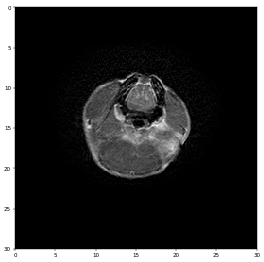

In [65]:
sitk_showNorm(imgOriginal)

In [96]:
idxSlice = 10
imgOriginal02 = imgOriginalVolume[:,:,idxSlice]

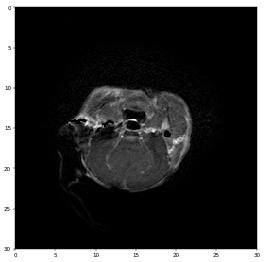

In [97]:
sitk_showNorm(imgOriginal02)

## Apply Smoothing

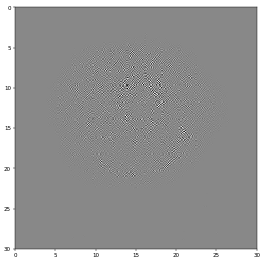

In [68]:
# imgSmooth = SimpleITK.CurvatureFlow(image1=imgOriginal,
#                                     timeStep=0.125,
#                                     numberOfIterations=5)

# # blurFilter = SimpleITK.CurvatureFlowImageFilter()
# # blurFilter.SetNumberOfIterations(5)
# # blurFilter.SetTimeStep(0.125)
# # imgSmooth = blurFilter.Execute(imgOriginal)

# sitk_showNorm(imgSmooth)

## Segmentation

### First Slice

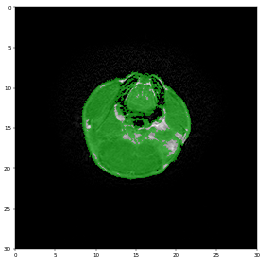

In [91]:
lstSeeds = [(130,170)]

imgWhiteMatter = SimpleITK.ConfidenceConnected(image1=imgOriginal, 
                                               seedList=lstSeeds,
                                               numberOfIterations=5,
                                               multiplier=3,
                                               replaceValue=labelWhiteMatter)

imgSmoothInt = SimpleITK.Cast(SimpleITK.RescaleIntensity(imgOriginal), imgWhiteMatter.GetPixelID())

sitk_show(SimpleITK.LabelOverlay(imgSmoothInt, imgWhiteMatter))

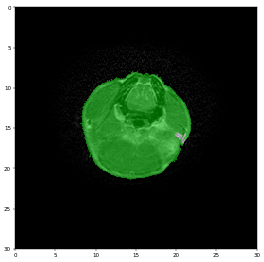

In [92]:
imgWhiteMatterNoHoles = SimpleITK.BinaryClosingByReconstruction(imgWhiteMatter, 100)

sitk_show(SimpleITK.LabelOverlay(imgSmoothInt, imgWhiteMatterNoHoles))

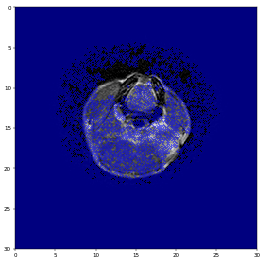

In [93]:
lstSeeds = [(119, 83), (198, 80), (100,100), (185, 102), (164, 43)]

imgGrayMatter = SimpleITK.ConfidenceConnected(image1=imgSmooth, 
                                              seedList=lstSeeds,
                                              numberOfIterations=3,
                                              multiplier=1.75,
                                              replaceValue=labelGrayMatter)

sitk_show(SimpleITK.LabelOverlay(imgSmoothInt, imgGrayMatter))

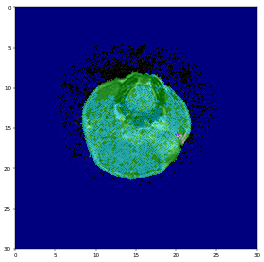

In [94]:
imgLabels = imgWhiteMatterNoHoles | imgGrayMatter


sitk_show(SimpleITK.LabelOverlay(imgSmoothInt, imgLabels))

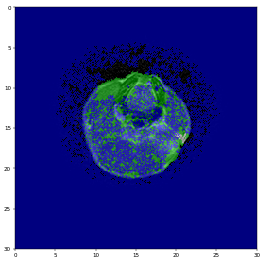

In [95]:
imgMask= imgWhiteMatterNoHoles/labelWhiteMatter * imgGrayMatter/labelGrayMatter
imgWhiteMatterNoHoles -= imgMask*labelWhiteMatter

imgLabels = imgWhiteMatterNoHoles + imgGrayMatter

sitk_show(SimpleITK.LabelOverlay(imgSmoothInt, imgLabels))

### Second Slice

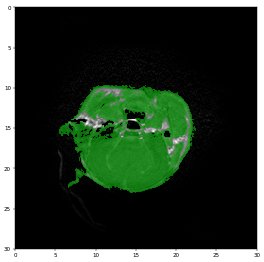

In [98]:
lstSeeds = [(130,170)]

imgWhiteMatter = SimpleITK.ConfidenceConnected(image1=imgOriginal02, 
                                               seedList=lstSeeds,
                                               numberOfIterations=5,
                                               multiplier=3,
                                               replaceValue=labelWhiteMatter)

imgSmoothInt = SimpleITK.Cast(SimpleITK.RescaleIntensity(imgOriginal02), imgWhiteMatter.GetPixelID())

sitk_show(SimpleITK.LabelOverlay(imgSmoothInt, imgWhiteMatter))

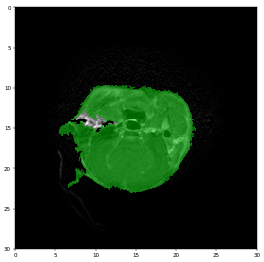

In [99]:
imgWhiteMatterNoHoles = SimpleITK.BinaryClosingByReconstruction(imgWhiteMatter, 100)

sitk_show(SimpleITK.LabelOverlay(imgSmoothInt, imgWhiteMatterNoHoles))